<a href="https://colab.research.google.com/github/ZohebAbai/Deep-Learning-Projects/blob/master/Online_Challenges_Hackathons/Synapse%20Dreams/malaria_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp -r 'drive/My Drive/Malaria' 'data/'

In [0]:
train_data = pd.read_csv('data/SubCh1_TrainingData.csv')
train_data.head()

,Sample_Name,Isolate,Timepoint,Treatment,BioRep,MAL1_465720_465873_bc__rv__,MAL1_48287_48430____kr___can,MAL1_562126_562246_bc__r___,MAL1_59416_59687____kr___can,MAL1_616633_616682_______y_,MAL10_1139073_1139243____kr,MAL10_258733_258825_b___r__,MAL10_271753_271892_bcgkrvy,MAL10_273174_273239_____r__,MAL10_416036_416142___g____,MAL10_947605_947888_b__kr__,MAL11_1116008_1116068_____r,MAL11_1839112_1839193____k_,MAL11_228710_228826_b_gk___,MAL11_390127_390200__cg___y,MAL11_42992_43250_bc_kr___c,MAL11_557615_557686_____r__,MAL11_804991_805237__c__r__,MAL12_1252815_1253072_bcg_,MAL12_1297315_1297410_____,MAL12_1516930_1517011____k,MAL12_1518573_1518702_b__k,MAL12_161842_161903____kr_,MAL12_1715356_1715487_b__k,MAL12_1745293_1745457_____,MAL12_354467_354531_______,MAL12_659493_659644__c_kr_,MAL13_1042932_1042987____k,MAL13_1213708_1213907_bcgk,MAL13_1349736_1349797___gk,MAL13_1676588_1676677_____,MAL13_243882_244060_bcgkrv,MAL13_2799275_2799445_b_gk,MAL13_2801236_2801354___gk,MAL13_477337_477393_____r_,...,PF3D7_1476100,PF3D7_1476200,PF3D7_1476300,PF3D7_1476400,PF3D7_1476500,PF3D7_1476600,PF3D7_1476700,PF3D7_1476800,PF3D7_1476900,PF3D7_1477000,PF3D7_1477100,PF3D7_1477200,PF3D7_1477300,PF3D7_1477400,PF3D7_1477500,PF3D7_1477600,PF3D7_1477700,PF3D7_1477800,PF3D7_1477900,PF3D7_1478000,PF3D7_1478100,PF3D7_1478200,PF3D7_1478300,PF3D7_1478400,PF3D7_1478500,PF3D7_1478600,PF3D7_1478700,PF3D7_1478800,PF3D7_1478900,PF3D7_1479000,PF3D7_1479200,PF3D7_1479400,PF3D7_1479500,PF3D7_1479600,PF3D7_1479700,PF3D7_1479800,PF3D7_1479900,PF3D7_1480000,PF3D7_1480100,DHA_IC50
0,isolate_01.24HR.DHA.BRep1,isolate_01,24HR,DHA,BRep1,0.008286,-0.959492,0.206468,-0.443936,0.453030,0.291222,-0.157282,-1.676810,0.377070,0.330400,-0.867864,1.310218,1.506423,-0.644621,-2.200778,0.295921,0.905085,0.031300,-0.400912,0.671349,-1.975516,1.014206,-0.673696,0.357644,1.943180,0.454974,1.005457,-0.002920,1.366547,-1.195826,-0.600248,-0.184329,0.152018,0.403741,-0.694524,...,0.866026,-1.136228,0.408677,-1.140128,0.797028,-0.996586,0.532532,-0.773071,-0.499282,-0.639428,0.899590,1.583275,-1.670416,-0.460963,-2.224315,-1.203750,-0.895934,-1.566585,0.740583,-1.163296,-1.556430,1.438021,1.879903,0.851503,0.865165,-1.187744,1.198509,-0.485618,-0.279651,0.210607,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528,2.177
1,isolate_01.24HR.DHA.BRep2,isolate_01,24HR,DHA,BRep2,-0.872028,-1.968558,-2.308563,-1.186611,0.508575,-0.368476,2.566465,0.366850,1.289160,-0.513018,-1.274157,0.666486,-0.370542,-2.569813,-2.866767,-1.413323,0.321271,-1.806634,0.377905,0.488721,0.208615,-1.148933,-0.571271,-1.222029,4.788899,-1.688973,0.539886,1.379208,-1.640111,-1.012102,0.197912,0.353742,-0.074718,-0.379069,-0.551554,...,-0.583646,-0.726289,1.001486,1.648376,-0.075690,0.037364,0.454881,0.868928,0.304638,0.013986,-0.717996,1.596225,0.878933,2.287396,-1.090007,-1.599586,1.503271,0.194582,-0.559752,1.522183,1.380381,-0.408926,1.448936,-0.671810,-0.384890,0.691912,-0.595123,0.067957,0.255640,-0.447109,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568,2.177
2,isolate_01.24HR.UT.BRep1,isolate_01,24HR,UT,BRep1,0.039480,-1.291371,-0.946661,-0.538092,-1.778501,1.037573,1.733154,1.454916,2.330948,-1.758676,-1.272294,0.817336,-0.691004,-1.899245,-1.525102,-0.782340,0.813996,-1.230456,0.423425,1.074828,0.810772,-0.500761,0.984006,-0.739337,4.577755,-0.771744,1.109504,2.193571,-1.568891,0.303967,-1.027229,1.720722,-1.823821,-0.236278,1.233397,...,0.501455,2.295911,-0.277815,2.093868,-0.761180,0.561973,0.919024,2.079097,1.085059,2.479581,-0.661316,0.835502,1.975719,2.368091,0.631246,-1.420637,0.983322,-0.098294,-0.637809,1.931367,0.800249,-0.369478,1.048414,-0.269290,-0.098820,2.230317,-0.179335,1.958688,0.349614,-0.780016,1.411557,-5.500522,-1.764229,-1.947208,-5.331037,-0.814417,-2.141285,-3.922684,-2.495169,2.177
3,isolate_01.24HR.UT.BRep2,isolate_01,24HR,UT,BRep2,0.125177,-1.462758,-1.888105,-0.828352,-1.410803,0.926191,2.644319,-0

In [0]:
test_data = pd.read_csv('data/SubCh1_TestData.csv')
test_data.head()

,Sample_Names,Isolate,Timepoint,Treatment,BioRep,MAL1_465720_465873_bc__rv__,MAL1_48287_48430____kr___can,MAL1_562126_562246_bc__r___,MAL1_59416_59687____kr___can,MAL1_616633_616682_______y_,MAL10_1139073_1139243____kr,MAL10_258733_258825_b___r__,MAL10_271753_271892_bcgkrvy,MAL10_273174_273239_____r__,MAL10_416036_416142___g____,MAL10_947605_947888_b__kr__,MAL11_1116008_1116068_____r,MAL11_1839112_1839193____k_,MAL11_228710_228826_b_gk___,MAL11_390127_390200__cg___y,MAL11_42992_43250_bc_kr___c,MAL11_557615_557686_____r__,MAL11_804991_805237__c__r__,MAL12_1252815_1253072_bcg_,MAL12_1297315_1297410_____,MAL12_1516930_1517011____k,MAL12_1518573_1518702_b__k,MAL12_161842_161903____kr_,MAL12_1715356_1715487_b__k,MAL12_1745293_1745457_____,MAL12_354467_354531_______,MAL12_659493_659644__c_kr_,MAL13_1042932_1042987____k,MAL13_1213708_1213907_bcgk,MAL13_1349736_1349797___gk,MAL13_1676588_1676677_____,MAL13_243882_244060_bcgkrv,MAL13_2799275_2799445_b_gk,MAL13_2801236_2801354___gk,MAL13_477337_477393_____r_,...,PF3D7_1476100,PF3D7_1476200,PF3D7_1476300,PF3D7_1476400,PF3D7_1476500,PF3D7_1476600,PF3D7_1476700,PF3D7_1476800,PF3D7_1476900,PF3D7_1477000,PF3D7_1477100,PF3D7_1477200,PF3D7_1477300,PF3D7_1477400,PF3D7_1477500,PF3D7_1477600,PF3D7_1477700,PF3D7_1477800,PF3D7_1477900,PF3D7_1478000,PF3D7_1478100,PF3D7_1478200,PF3D7_1478300,PF3D7_1478400,PF3D7_1478500,PF3D7_1478600,PF3D7_1478700,PF3D7_1478800,PF3D7_1478900,PF3D7_1479000,PF3D7_1479200,PF3D7_1479400,PF3D7_1479500,PF3D7_1479600,PF3D7_1479700,PF3D7_1479800,PF3D7_1479900,PF3D7_1480000,PF3D7_1480100,DHA_IC50
0,isolate_31.24HR.DHA.BRep1,isolate_31,24HR,DHA,BRep1,0.416583,-2.304394,-1.279308,-1.128485,0.129698,0.871030,1.572525,0.651682,2.538760,0.573149,-1.082851,0.936832,0.087507,-2.854530,-1.499803,-0.773197,0.419043,-1.013979,0.260906,1.654474,-2.130734,-1.079080,0.458596,-0.925080,4.290594,-1.381932,0.500749,1.286738,-2.418493,-0.806408,-1.604329,0.837758,-0.632632,-0.366333,-0.125206,...,-0.729301,0.484338,-0.063779,0.904931,-0.517796,0.119480,-0.057968,1.090016,-0.343838,0.500812,0.014008,1.882412,0.305182,0.675700,0.936805,-0.814474,-0.586068,-0.682156,-1.043013,0.409791,0.237473,-0.819344,1.822526,0.330590,-0.233672,1.751535,0.564866,0.215629,-1.014545,-0.962286,0.117763,-1.650283,-0.520373,-1.301428,-5.326124,-0.352736,-1.567931,-4.446439,-1.875440,NaN
1,isolate_31.24HR.DHA.BRep2,isolate_31,24HR,DHA,BRep2,0.247195,-2.176939,-1.470318,-0.676434,-0.206543,0.902257,0.922677,-0.722047,1.627910,1.172958,-0.455679,1.433261,0.457692,-2.683650,-1.886919,-0.825374,0.801392,-0.635466,-0.071490,1.547044,-2.426414,-0.462118,0.268388,-0.011601,3.843393,-1.037581,0.236493,2.100788,-1.655354,-1.502491,0.986317,0.454865,-0.081720,-0.067334,-0.952454,...,-0.464320,-1.375715,0.128451,1.026830,-0.520076,-0.664132,0.522911,2.086780,-0.650356,-0.872343,0.076575,2.187431,-0.915064,0.684874,-1.956101,-0.942113,-0.546577,0.600632,-0.546255,1.322332,1.382481,-0.108385,1.700699,0.068653,0.089634,-0.731700,0.830997,1.113049,-0.972131,-0.293063,0.472336,-1.151134,-0.342707,-1.001569,-5.337602,-0.672201,-1.494983,-4.299427,-1.553652,NaN
2,isolate_31.24HR.UT.BRep1,isolate_31,24HR,UT,BRep1,-0.197699,-0.572531,0.270896,0.557528,-0.698585,0.432209,1.242174,0.509054,1.080989,-0.036372,-1.387962,1.235317,-0.736499,-2.672685,-2.555460,-0.729578,-0.237640,-1.217110,-0.064621,0.820110,-2.363569,-1.369570,-0.510715,-1.404069,2.177829,-0.684020,0.008728,0.841260,-1.108520,-1.113841,-0.801792,0.142905,0.432826,-0.121049,-0.682292,...,0.373855,-0.073820,0.506702,0.985586,-0.200574,-0.368940,0.773008,0.880273,-0.214238,1.343891,0.068878,1.768421,-0.710690,0.377892,0.125968,-1.734735,0.172204,-1.037252,-0.048031,0.452233,-0.637193,0.483858,0.773591,-0.063690,0.280694,1.684919,0.576948,-0.275431,-0.707389,0.062575,-0.309768,-6.330446,-0.850889,-1.603832,-3.256602,-2.517157,-0.650735,-4.841146,0.153951,NaN
3,isolate_31.24HR.UT.BRep2,isolate_31,24HR,UT,BRep2,0.966916,-1.723830,-1.102392,-0.797996,0.032847,0.561402,1.262912,-1.

**For Understanding:**

1. Sample_Names = Unique identifier for each sample
2. Isolate = Parasite sample name. Each isolate is a parasite sample isolated from a single patient. 
3. Timepoint = Estimated time after invasion which transcription sample was collected. Two options are available here 6hr or 24hr. Malaria has a 48hr life cycle in the blood stage and has very different development/transcription/biology at these two timepoints.
4. Treatment = Whether the transcription sample was either perturbed with 5nM DHA or perturbed with DMSO (our control, listed as UT in dataset).
5. BioRep = Biological Replicate. Indicates which biological replicate. Options available are Brep1 to Brep8.

The training data set will be used to build a model to predict the IC50 of the test data sets. The training data set consists of 30 parasite isolates (or lines) whilst the test set consists of 25 parasite isolates. 

In [0]:
train_data.BioRep.value_counts()

BRep1    120
BRep2    120
BRep3      8
BRep4      8
BRep8      4
BRep5      4
BRep6      4
BRep7      4
Name: BioRep, dtype: int64

Total samples = 30 isolates x 2 timepoints x 2 treatments x 8 biorep

In [0]:
test_data.BioRep.value_counts()

BRep1    100
BRep2    100
Name: BioRep, dtype: int64

training data : Slight skewed distribution

In [0]:
for i in range(1,31):
  if i <10: 
    print(train_data[train_data.Isolate=='isolate_0'+str(i)]['DHA_IC50'].nunique())
  else:
    print(train_data[train_data.Isolate=='isolate_'+str(i)]['DHA_IC50'].nunique()) 

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


**Ever subgroups has unique DHA_IC50 values**

## Data Preprocessing

In [0]:
#Any null value?
train_data.isnull().sum(axis = 0).any()

False

In [0]:
test_data.isnull().sum(axis = 0).any()

True

last column is null here, we will remove them

**Delete Rows Containing BioRep more than 1 and 2**

In [0]:
ind = []
for i in range(3,9):
  ind.append(train_data[train_data.BioRep == 'BRep'+str(i)].index)

In [0]:
for i in ind:
  train_data.drop(i, inplace=True)

In [0]:
train_data = train_data.reset_index(drop=True)

In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Columns: 5546 entries, Sample_Name to DHA_IC50
dtypes: float64(5541), object(5)
memory usage: 10.2+ MB


### Approach 1

One row for each isolates

**Create Final Cols Names for both dataset**

In [0]:
names = ['24HR_DHA_BRep1','24HR_DHA_BRep2','24HR_UT_BRep1','24HR_UT_BRep2', '6HR_DHA_BRep1','6HR_DHA_BRep2','6HR_UT_BRep1','6HR_UT_BRep2']
cols = list(train_data.columns)[5:-1]
final_cols=[]
for name in names:
  for col in cols:
    final_cols.append(col+'_'+name) 
len(final_cols)

44320

**Segregate every Isolates subgroups for train data and join them**



In [0]:
train_X = pd.DataFrame([])

for i in range(1,31):
  if i < 10:
    df_isolate_tmp = train_data[train_data.Isolate=='isolate_0'+str(i)].drop(['Sample_Name','Isolate', 'Timepoint', 'Treatment', 'BioRep', 'DHA_IC50'], axis=1)
    isolate_tmp_series = pd.Series(df_isolate_tmp.T.values.ravel('F'))
    train_isolate_tmp = pd.DataFrame({'isolate_0'+str(i) : isolate_tmp_series}).T
    train_X = train_X.append(train_isolate_tmp, ignore_index=True)
  else:
    df_isolate_tmp = train_data[train_data.Isolate=='isolate_'+str(i)].drop(['Sample_Name','Isolate', 'Timepoint', 'Treatment', 'BioRep', 'DHA_IC50'], axis=1)
    isolate_tmp_series = pd.Series(df_isolate_tmp.T.values.ravel('F'))
    train_isolate_tmp = pd.DataFrame({'isolate_'+str(i) : isolate_tmp_series}).T
    train_X = train_X.append(train_isolate_tmp, ignore_index=True)

train_X.columns = final_cols
train_X.head()

,MAL1_465720_465873_bc__rv___24HR_DHA_BRep1,MAL1_48287_48430____kr___can_24HR_DHA_BRep1,MAL1_562126_562246_bc__r____24HR_DHA_BRep1,MAL1_59416_59687____kr___can_24HR_DHA_BRep1,MAL1_616633_616682_______y__24HR_DHA_BRep1,MAL10_1139073_1139243____kr_24HR_DHA_BRep1,MAL10_258733_258825_b___r___24HR_DHA_BRep1,MAL10_271753_271892_bcgkrvy_24HR_DHA_BRep1,MAL10_273174_273239_____r___24HR_DHA_BRep1,MAL10_416036_416142___g_____24HR_DHA_BRep1,MAL10_947605_947888_b__kr___24HR_DHA_BRep1,MAL11_1116008_1116068_____r_24HR_DHA_BRep1,MAL11_1839112_1839193____k__24HR_DHA_BRep1,MAL11_228710_228826_b_gk____24HR_DHA_BRep1,MAL11_390127_390200__cg___y_24HR_DHA_BRep1,MAL11_42992_43250_bc_kr___c_24HR_DHA_BRep1,MAL11_557615_557686_____r___24HR_DHA_BRep1,MAL11_804991_805237__c__r___24HR_DHA_BRep1,MAL12_1252815_1253072_bcg__24HR_DHA_BRep1,MAL12_1297315_1297410______24HR_DHA_BRep1,MAL12_1516930_1517011____k_24HR_DHA_BRep1,MAL12_1518573_1518702_b__k_24HR_DHA_BRep1,MAL12_161842_161903____kr__24HR_DHA_BRep1,MAL12_1715356_1715487_b__k_24HR_DHA_BRep1,MAL12_1745293_1745457______24HR_DHA_BRep1,MAL12_354467_354531________24HR_DHA_BRep1,MAL12_659493_659644__c_kr__24HR_DHA_BRep1,MAL13_1042932_1042987____k_24HR_DHA_BRep1,MAL13_1213708_1213907_bcgk_24HR_DHA_BRep1,MAL13_1349736_1349797___gk_24HR_DHA_BRep1,MAL13_1676588_1676677______24HR_DHA_BRep1,MAL13_243882_244060_bcgkrv_24HR_DHA_BRep1,MAL13_2799275_2799445_b_gk_24HR_DHA_BRep1,MAL13_2801236_2801354___gk_24HR_DHA_BRep1,MAL13_477337_477393_____r__24HR_DHA_BRep1,MAL14_1062828_1062952__cgk_24HR_DHA_BRep1,MAL14_1147523_1147685_bc_k_24HR_DHA_BRep1,MAL14_1184520_1184577____k_24HR_DHA_BRep1,MAL14_130040_130112_bc_k_v_24HR_DHA_BRep1,MAL14_133308_133411_bcgk_v_24HR_DHA_BRep1,...,PF3D7_1476000_6HR_UT_BRep2,PF3D7_1476100_6HR_UT_BRep2,PF3D7_1476200_6HR_UT_BRep2,PF3D7_1476300_6HR_UT_BRep2,PF3D7_1476400_6HR_UT_BRep2,PF3D7_1476500_6HR_UT_BRep2,PF3D7_1476600_6HR_UT_BRep2,PF3D7_1476700_6HR_UT_BRep2,PF3D7_1476800_6HR_UT_BRep2,PF3D7_1476900_6HR_UT_BRep2,PF3D7_1477000_6HR_UT_BRep2,PF3D7_1477100_6HR_UT_BRep2,PF3D7_1477200_6HR_UT_BRep2,PF3D7_1477300_6HR_UT_BRep2,PF3D7_1477400_6HR_UT_BRep2,PF3D7_1477500_6HR_UT_BRep2,PF3D7_1477600_6HR_UT_BRep2,PF3D7_1477700_6HR_UT_BRep2,PF3D7_1477800_6HR_UT_BRep2,PF3D7_1477900_6HR_UT_BRep2,PF3D7_1478000_6HR_UT_BRep2,PF3D7_1478100_6HR_UT_BRep2,PF3D7_1478200_6HR_UT_BRep2,PF3D7_1478300_6HR_UT_BRep2,PF3D7_1478400_6HR_UT_BRep2,PF3D7_1478500_6HR_UT_BRep2,PF3D7_1478600_6HR_UT_BRep2,PF3D7_1478700_6HR_UT_BRep2,PF3D7_1478800_6HR_UT_BRep2,PF3D7_1478900_6HR_UT_BRep2,PF3D7_1479000_6HR_UT_BRep2,PF3D7_1479200_6HR_UT_BRep2,PF3D7_1479400_6HR_UT_BRep2,PF3D7_1479500_6HR_UT_BRep2,PF3D7_1479600_6HR_UT_BRep2,PF3D7_1479700_6HR_UT_BRep2,PF3D7_1479800_6HR_UT_BRep2,PF3D7_1479900_6HR_UT_BRep2,PF3D7_1480000_6HR_UT_BRep2,PF3D7_1480100_6HR_UT_BRep2
0,0.008286,-0.959492,0.206468,-0.443936,0.453030,0.291222,-0.157282,-1.676810,0.377070,0.330400,-0.867864,1.310218,1.506423,-0.644621,-2.200778,0.295921,0.905085,0.031300,-0.400912,0.671349,-1.975516,1.014206,-0.673696,0.357644,1.943180,0.454974,1.005457,-0.002920,1.366547,-1.195826,-0.600248,-0.184329,0.152018,0.403741,-0.694524,-0.271579,0.747548,1.264195,0.818468,-0.896662,...,1.042256,-1.013670,-0.373979,0.955578,2.583200,-1.136387,-0.607732,0.538165,1.859154,-0.191505,-0.624884,-0.766799,1.191210,0.540717,1.073057,-0.936968,-2.108191,-0.122498,1.355693,-0.991552,2.786734,1.742952,-1.014183,0.691649,-0.642727,-0.742781,0.047234,0.034487,1.462098,0.319745,0.881373,-0.136047,-4.869960,-1.340846,-2.424770,-4.075909,-0.819760,-2.626978,-4.087643,-2.247185
1,-0.178971,-1.922426,-1.875015,-1.484605,-0.233600,0.266478,2.104848,0.040688,0.943437,-0.408265,-0.839884,0.869626,-0.513301,-3.084092,-2.276578,-1.260385,0.933086,-0.203035,-0.482117,0.797876,-0.650832,-1.067428,-0.333363,-1.300101,3.879392,-1.803044,0.565216,1.226175,-1.682256,-1.040228,1.161033,0.290633,0.006105,0.016718,-1.252039,0.444497,-0.677850,-0.491315,0.646079,-1.038779,...,0.503879,0.595889,-0.189438,-0.417791,1.045967,0.137532,0.0

**Segregate every Isolates subgroups for test data and join them**

In [0]:
test_X = pd.DataFrame([])

for i in range(31,56):
  if i < 10:
    df_isolate_tmp = test_data[test_data.Isolate=='isolate_0'+str(i)].drop(['Sample_Names','Isolate', 'Timepoint', 'Treatment', 'BioRep', 'DHA_IC50'], axis=1)
    isolate_tmp_series = pd.Series(df_isolate_tmp.T.values.ravel('F'))
    test_isolate_tmp = pd.DataFrame({'isolate_0'+str(i) : isolate_tmp_series}).T
    test_X = test_X.append(test_isolate_tmp, ignore_index=True)
  else:
    df_isolate_tmp = test_data[test_data.Isolate=='isolate_'+str(i)].drop(['Sample_Names','Isolate', 'Timepoint', 'Treatment', 'BioRep', 'DHA_IC50'], axis=1)
    isolate_tmp_series = pd.Series(df_isolate_tmp.T.values.ravel('F'))
    test_isolate_tmp = pd.DataFrame({'isolate_'+str(i) : isolate_tmp_series}).T
    test_X = test_X.append(test_isolate_tmp, ignore_index=True)

test_X.columns = final_cols
test_X.head()

,MAL1_465720_465873_bc__rv___24HR_DHA_BRep1,MAL1_48287_48430____kr___can_24HR_DHA_BRep1,MAL1_562126_562246_bc__r____24HR_DHA_BRep1,MAL1_59416_59687____kr___can_24HR_DHA_BRep1,MAL1_616633_616682_______y__24HR_DHA_BRep1,MAL10_1139073_1139243____kr_24HR_DHA_BRep1,MAL10_258733_258825_b___r___24HR_DHA_BRep1,MAL10_271753_271892_bcgkrvy_24HR_DHA_BRep1,MAL10_273174_273239_____r___24HR_DHA_BRep1,MAL10_416036_416142___g_____24HR_DHA_BRep1,MAL10_947605_947888_b__kr___24HR_DHA_BRep1,MAL11_1116008_1116068_____r_24HR_DHA_BRep1,MAL11_1839112_1839193____k__24HR_DHA_BRep1,MAL11_228710_228826_b_gk____24HR_DHA_BRep1,MAL11_390127_390200__cg___y_24HR_DHA_BRep1,MAL11_42992_43250_bc_kr___c_24HR_DHA_BRep1,MAL11_557615_557686_____r___24HR_DHA_BRep1,MAL11_804991_805237__c__r___24HR_DHA_BRep1,MAL12_1252815_1253072_bcg__24HR_DHA_BRep1,MAL12_1297315_1297410______24HR_DHA_BRep1,MAL12_1516930_1517011____k_24HR_DHA_BRep1,MAL12_1518573_1518702_b__k_24HR_DHA_BRep1,MAL12_161842_161903____kr__24HR_DHA_BRep1,MAL12_1715356_1715487_b__k_24HR_DHA_BRep1,MAL12_1745293_1745457______24HR_DHA_BRep1,MAL12_354467_354531________24HR_DHA_BRep1,MAL12_659493_659644__c_kr__24HR_DHA_BRep1,MAL13_1042932_1042987____k_24HR_DHA_BRep1,MAL13_1213708_1213907_bcgk_24HR_DHA_BRep1,MAL13_1349736_1349797___gk_24HR_DHA_BRep1,MAL13_1676588_1676677______24HR_DHA_BRep1,MAL13_243882_244060_bcgkrv_24HR_DHA_BRep1,MAL13_2799275_2799445_b_gk_24HR_DHA_BRep1,MAL13_2801236_2801354___gk_24HR_DHA_BRep1,MAL13_477337_477393_____r__24HR_DHA_BRep1,MAL14_1062828_1062952__cgk_24HR_DHA_BRep1,MAL14_1147523_1147685_bc_k_24HR_DHA_BRep1,MAL14_1184520_1184577____k_24HR_DHA_BRep1,MAL14_130040_130112_bc_k_v_24HR_DHA_BRep1,MAL14_133308_133411_bcgk_v_24HR_DHA_BRep1,...,PF3D7_1476000_6HR_UT_BRep2,PF3D7_1476100_6HR_UT_BRep2,PF3D7_1476200_6HR_UT_BRep2,PF3D7_1476300_6HR_UT_BRep2,PF3D7_1476400_6HR_UT_BRep2,PF3D7_1476500_6HR_UT_BRep2,PF3D7_1476600_6HR_UT_BRep2,PF3D7_1476700_6HR_UT_BRep2,PF3D7_1476800_6HR_UT_BRep2,PF3D7_1476900_6HR_UT_BRep2,PF3D7_1477000_6HR_UT_BRep2,PF3D7_1477100_6HR_UT_BRep2,PF3D7_1477200_6HR_UT_BRep2,PF3D7_1477300_6HR_UT_BRep2,PF3D7_1477400_6HR_UT_BRep2,PF3D7_1477500_6HR_UT_BRep2,PF3D7_1477600_6HR_UT_BRep2,PF3D7_1477700_6HR_UT_BRep2,PF3D7_1477800_6HR_UT_BRep2,PF3D7_1477900_6HR_UT_BRep2,PF3D7_1478000_6HR_UT_BRep2,PF3D7_1478100_6HR_UT_BRep2,PF3D7_1478200_6HR_UT_BRep2,PF3D7_1478300_6HR_UT_BRep2,PF3D7_1478400_6HR_UT_BRep2,PF3D7_1478500_6HR_UT_BRep2,PF3D7_1478600_6HR_UT_BRep2,PF3D7_1478700_6HR_UT_BRep2,PF3D7_1478800_6HR_UT_BRep2,PF3D7_1478900_6HR_UT_BRep2,PF3D7_1479000_6HR_UT_BRep2,PF3D7_1479200_6HR_UT_BRep2,PF3D7_1479400_6HR_UT_BRep2,PF3D7_1479500_6HR_UT_BRep2,PF3D7_1479600_6HR_UT_BRep2,PF3D7_1479700_6HR_UT_BRep2,PF3D7_1479800_6HR_UT_BRep2,PF3D7_1479900_6HR_UT_BRep2,PF3D7_1480000_6HR_UT_BRep2,PF3D7_1480100_6HR_UT_BRep2
0,0.416583,-2.304394,-1.279308,-1.128485,0.129698,0.871030,1.572525,0.651682,2.538760,0.573149,-1.082851,0.936832,0.087507,-2.854530,-1.499803,-0.773197,0.419043,-1.013979,0.260906,1.654474,-2.130734,-1.079080,0.458596,-0.925080,4.290594,-1.381932,0.500749,1.286738,-2.418493,-0.806408,-1.604329,0.837758,-0.632632,-0.366333,-0.125206,1.175735,-0.435809,-2.293374,-0.845560,-0.913878,...,1.126481,-0.923814,0.184039,-1.016913,2.312472,-0.288934,0.611849,0.066310,0.488075,1.133445,-0.214559,0.112039,0.725452,1.270118,1.433050,0.650938,-3.217995,0.420957,-1.060678,-0.082462,1.658251,0.545712,-0.630140,0.135006,-0.272726,-0.246296,1.570403,0.352790,0.082779,-0.397901,-0.333969,0.595847,-3.919576,-2.774839,-1.575720,-4.255767,-3.448939,-1.596854,-4.798407,-2.646275
1,0.563237,-1.962995,-0.995269,-1.386620,-1.306784,-0.031462,2.041137,0.001222,2.005863,0.146241,-1.147457,1.279086,0.217820,-2.085243,-1.282592,-1.405527,-0.009473,-1.208298,0.970508,1.244942,-2.843201,-0.804957,0.414698,-1.379742,3.826293,-1.198543,0.357112,1.070763,-2.091302,-0.980283,-1.639148,1.195823,0.123545,-0.324929,-0.359223,0.511611,-0.516247,-1.690180,0.332457,-0.937236,...,1.018059,-1.616524,-0.509980,0.902273,1.708071,-1.161495,0

In [0]:
#Labels for training set
y = train_data['DHA_IC50'].unique()

In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(train_X)
X_test = sc.fit_transform(test_X)

In [0]:
print(X_train.shape, X_test.shape)

(30, 44320) (25, 44320)


### 2nd approach

Keep 8 sub rows for every row as it is 

In [0]:
#Drop first5 columns
train_data.drop(['Sample_Name', 'Isolate', 'Timepoint', 'Treatment', 'BioRep'],axis=1,inplace=True)
train_data.head()

,MAL1_465720_465873_bc__rv__,MAL1_48287_48430____kr___can,MAL1_562126_562246_bc__r___,MAL1_59416_59687____kr___can,MAL1_616633_616682_______y_,MAL10_1139073_1139243____kr,MAL10_258733_258825_b___r__,MAL10_271753_271892_bcgkrvy,MAL10_273174_273239_____r__,MAL10_416036_416142___g____,MAL10_947605_947888_b__kr__,MAL11_1116008_1116068_____r,MAL11_1839112_1839193____k_,MAL11_228710_228826_b_gk___,MAL11_390127_390200__cg___y,MAL11_42992_43250_bc_kr___c,MAL11_557615_557686_____r__,MAL11_804991_805237__c__r__,MAL12_1252815_1253072_bcg_,MAL12_1297315_1297410_____,MAL12_1516930_1517011____k,MAL12_1518573_1518702_b__k,MAL12_161842_161903____kr_,MAL12_1715356_1715487_b__k,MAL12_1745293_1745457_____,MAL12_354467_354531_______,MAL12_659493_659644__c_kr_,MAL13_1042932_1042987____k,MAL13_1213708_1213907_bcgk,MAL13_1349736_1349797___gk,MAL13_1676588_1676677_____,MAL13_243882_244060_bcgkrv,MAL13_2799275_2799445_b_gk,MAL13_2801236_2801354___gk,MAL13_477337_477393_____r_,MAL14_1062828_1062952__cgk,MAL14_1147523_1147685_bc_k,MAL14_1184520_1184577____k,MAL14_130040_130112_bc_k_v,MAL14_133308_133411_bcgk_v,...,PF3D7_1476100,PF3D7_1476200,PF3D7_1476300,PF3D7_1476400,PF3D7_1476500,PF3D7_1476600,PF3D7_1476700,PF3D7_1476800,PF3D7_1476900,PF3D7_1477000,PF3D7_1477100,PF3D7_1477200,PF3D7_1477300,PF3D7_1477400,PF3D7_1477500,PF3D7_1477600,PF3D7_1477700,PF3D7_1477800,PF3D7_1477900,PF3D7_1478000,PF3D7_1478100,PF3D7_1478200,PF3D7_1478300,PF3D7_1478400,PF3D7_1478500,PF3D7_1478600,PF3D7_1478700,PF3D7_1478800,PF3D7_1478900,PF3D7_1479000,PF3D7_1479200,PF3D7_1479400,PF3D7_1479500,PF3D7_1479600,PF3D7_1479700,PF3D7_1479800,PF3D7_1479900,PF3D7_1480000,PF3D7_1480100,DHA_IC50
0,0.008286,-0.959492,0.206468,-0.443936,0.453030,0.291222,-0.157282,-1.676810,0.377070,0.330400,-0.867864,1.310218,1.506423,-0.644621,-2.200778,0.295921,0.905085,0.031300,-0.400912,0.671349,-1.975516,1.014206,-0.673696,0.357644,1.943180,0.454974,1.005457,-0.002920,1.366547,-1.195826,-0.600248,-0.184329,0.152018,0.403741,-0.694524,-0.271579,0.747548,1.264195,0.818468,-0.896662,...,0.866026,-1.136228,0.408677,-1.140128,0.797028,-0.996586,0.532532,-0.773071,-0.499282,-0.639428,0.899590,1.583275,-1.670416,-0.460963,-2.224315,-1.203750,-0.895934,-1.566585,0.740583,-1.163296,-1.556430,1.438021,1.879903,0.851503,0.865165,-1.187744,1.198509,-0.485618,-0.279651,0.210607,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528,2.177
1,-0.872028,-1.968558,-2.308563,-1.186611,0.508575,-0.368476,2.566465,0.366850,1.289160,-0.513018,-1.274157,0.666486,-0.370542,-2.569813,-2.866767,-1.413323,0.321271,-1.806634,0.377905,0.488721,0.208615,-1.148933,-0.571271,-1.222029,4.788899,-1.688973,0.539886,1.379208,-1.640111,-1.012102,0.197912,0.353742,-0.074718,-0.379069,-0.551554,0.210516,-0.724057,-1.169231,0.725601,-0.018499,...,-0.583646,-0.726289,1.001486,1.648376,-0.075690,0.037364,0.454881,0.868928,0.304638,0.013986,-0.717996,1.596225,0.878933,2.287396,-1.090007,-1.599586,1.503271,0.194582,-0.559752,1.522183,1.380381,-0.408926,1.448936,-0.671810,-0.384890,0.691912,-0.595123,0.067957,0.255640,-0.447109,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568,2.177
2,0.039480,-1.291371,-0.946661,-0.538092,-1.778501,1.037573,1.733154,1.454916,2.330948,-1.758676,-1.272294,0.817336,-0.691004,-1.899245,-1.525102,-0.782340,0.813996,-1.230456,0.423425,1.074828,0.810772,-0.500761,0.984006,-0.739337,4.577755,-0.771744,1.109504,2.193571,-1.568891,0.303967,-1.027229,1.720722,-1.823821,-0.236278,1.233397,0.387753,-0.032097,-1.689696,-0.328787,-0.469228,...,0.501455,2.295911,-0.277815,2.093868,-0.761180,0.561973,0.919024,2.079097,1.085059,2.479581,-0.661316,0.835502,1.975719,2.368091,0.631246,-1.420637,0.983322,-0.098294,-0.637809,1.931367,0.800249,-0.369478,1.048414,-0.269290,-0.098820,2.230317,-0.179335,1.958688,0.349614,-0.780016,1.411557,-5.500522,-1.764229,-1.947208,-5.331037,-0.814417,-2.141285,-3.922684,-2.495169,2.177
3,0.125177,-1.462758,-1.888105,-0.828352,-1

In [0]:
#Drop first5 and last column
test_data.drop(['Sample_Names', 'Isolate', 'Timepoint', 'Treatment', 'BioRep', 'DHA_IC50'],axis=1,inplace=True)
test_data.head()

,MAL1_465720_465873_bc__rv__,MAL1_48287_48430____kr___can,MAL1_562126_562246_bc__r___,MAL1_59416_59687____kr___can,MAL1_616633_616682_______y_,MAL10_1139073_1139243____kr,MAL10_258733_258825_b___r__,MAL10_271753_271892_bcgkrvy,MAL10_273174_273239_____r__,MAL10_416036_416142___g____,MAL10_947605_947888_b__kr__,MAL11_1116008_1116068_____r,MAL11_1839112_1839193____k_,MAL11_228710_228826_b_gk___,MAL11_390127_390200__cg___y,MAL11_42992_43250_bc_kr___c,MAL11_557615_557686_____r__,MAL11_804991_805237__c__r__,MAL12_1252815_1253072_bcg_,MAL12_1297315_1297410_____,MAL12_1516930_1517011____k,MAL12_1518573_1518702_b__k,MAL12_161842_161903____kr_,MAL12_1715356_1715487_b__k,MAL12_1745293_1745457_____,MAL12_354467_354531_______,MAL12_659493_659644__c_kr_,MAL13_1042932_1042987____k,MAL13_1213708_1213907_bcgk,MAL13_1349736_1349797___gk,MAL13_1676588_1676677_____,MAL13_243882_244060_bcgkrv,MAL13_2799275_2799445_b_gk,MAL13_2801236_2801354___gk,MAL13_477337_477393_____r_,MAL14_1062828_1062952__cgk,MAL14_1147523_1147685_bc_k,MAL14_1184520_1184577____k,MAL14_130040_130112_bc_k_v,MAL14_133308_133411_bcgk_v,...,PF3D7_1476000,PF3D7_1476100,PF3D7_1476200,PF3D7_1476300,PF3D7_1476400,PF3D7_1476500,PF3D7_1476600,PF3D7_1476700,PF3D7_1476800,PF3D7_1476900,PF3D7_1477000,PF3D7_1477100,PF3D7_1477200,PF3D7_1477300,PF3D7_1477400,PF3D7_1477500,PF3D7_1477600,PF3D7_1477700,PF3D7_1477800,PF3D7_1477900,PF3D7_1478000,PF3D7_1478100,PF3D7_1478200,PF3D7_1478300,PF3D7_1478400,PF3D7_1478500,PF3D7_1478600,PF3D7_1478700,PF3D7_1478800,PF3D7_1478900,PF3D7_1479000,PF3D7_1479200,PF3D7_1479400,PF3D7_1479500,PF3D7_1479600,PF3D7_1479700,PF3D7_1479800,PF3D7_1479900,PF3D7_1480000,PF3D7_1480100
0,0.416583,-2.304394,-1.279308,-1.128485,0.129698,0.871030,1.572525,0.651682,2.538760,0.573149,-1.082851,0.936832,0.087507,-2.854530,-1.499803,-0.773197,0.419043,-1.013979,0.260906,1.654474,-2.130734,-1.079080,0.458596,-0.925080,4.290594,-1.381932,0.500749,1.286738,-2.418493,-0.806408,-1.604329,0.837758,-0.632632,-0.366333,-0.125206,1.175735,-0.435809,-2.293374,-0.845560,-0.913878,...,0.291847,-0.729301,0.484338,-0.063779,0.904931,-0.517796,0.119480,-0.057968,1.090016,-0.343838,0.500812,0.014008,1.882412,0.305182,0.675700,0.936805,-0.814474,-0.586068,-0.682156,-1.043013,0.409791,0.237473,-0.819344,1.822526,0.330590,-0.233672,1.751535,0.564866,0.215629,-1.014545,-0.962286,0.117763,-1.650283,-0.520373,-1.301428,-5.326124,-0.352736,-1.567931,-4.446439,-1.875440
1,0.247195,-2.176939,-1.470318,-0.676434,-0.206543,0.902257,0.922677,-0.722047,1.627910,1.172958,-0.455679,1.433261,0.457692,-2.683650,-1.886919,-0.825374,0.801392,-0.635466,-0.071490,1.547044,-2.426414,-0.462118,0.268388,-0.011601,3.843393,-1.037581,0.236493,2.100788,-1.655354,-1.502491,0.986317,0.454865,-0.081720,-0.067334,-0.952454,2.014716,-0.136527,-1.248089,-0.495562,-0.522839,...,0.532201,-0.464320,-1.375715,0.128451,1.026830,-0.520076,-0.664132,0.522911,2.086780,-0.650356,-0.872343,0.076575,2.187431,-0.915064,0.684874,-1.956101,-0.942113,-0.546577,0.600632,-0.546255,1.322332,1.382481,-0.108385,1.700699,0.068653,0.089634,-0.731700,0.830997,1.113049,-0.972131,-0.293063,0.472336,-1.151134,-0.342707,-1.001569,-5.337602,-0.672201,-1.494983,-4.299427,-1.553652
2,-0.197699,-0.572531,0.270896,0.557528,-0.698585,0.432209,1.242174,0.509054,1.080989,-0.036372,-1.387962,1.235317,-0.736499,-2.672685,-2.555460,-0.729578,-0.237640,-1.217110,-0.064621,0.820110,-2.363569,-1.369570,-0.510715,-1.404069,2.177829,-0.684020,0.008728,0.841260,-1.108520,-1.113841,-0.801792,0.142905,0.432826,-0.121049,-0.682292,0.532976,-0.480841,-0.582436,0.713789,-1.749020,...,-0.102947,0.373855,-0.073820,0.506702,0.985586,-0.200574,-0.368940,0.773008,0.880273,-0.214238,1.343891,0.068878,1.768421,-0.710690,0.377892,0.125968,-1.734735,0.172204,-1.037252,-0.048031,0.452233,-0.637193,0.483858,0.773591,-0.063690,0.280694,1.684919,0.576948,-0.275431,-0.707389,0.062575,-0.309768,-6.330446,-0.850889,-1.603832,-3.256602,-2.517157,-0.650735,-4.841146,0.153951
3,0.966916,-1.723830,

In [0]:
#Feature Columns
X= train_data.drop('DHA_IC50',axis=1)

#Labels
y= train_data['DHA_IC50']

In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X.astype(float))
X_test = sc.fit_transform(test_data.astype(float))

In [0]:
print(X_train.shape, X_test.shape)

(240, 5540) (200, 5540)


## Gradient Boosting Regression

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor(n_estimators=300, random_state = 101)
GBR.fit(X_train, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='auto',
                          random_state=101, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import mean_squared_error

y_pred_train = GBR.predict(X_train)
print(mean_squared_error(y, y_pred_train))

9.568420542923919e-08


## Model Evaluation

### For 1st approach

In [0]:
#Check r2 score for training set
from sklearn.metrics import r2_score
y_pred_train = GBR.predict(X_train)
print(r2_score(y_pred_train, y))

0.9999996975470312


In [0]:
#Check spearman r score for training set
from scipy.stats import spearmanr
print(spearmanr(y_pred_train,y))

SpearmanrResult(correlation=1.0, pvalue=0.0)


**hIghly positively correlated**

## Approach 2

In [0]:
#Check r2 score for training set
from sklearn.metrics import r2_score
y_pred_train = GBR.predict(X_train)
print(r2_score(y_pred_train, y))

0.9999933904238101


In [0]:
#Check spearman r score for training set
from scipy.stats import spearmanr
print(spearmanr(y_pred_train,y))

SpearmanrResult(correlation=0.9994460175163113, pvalue=0.0)


## Visualization

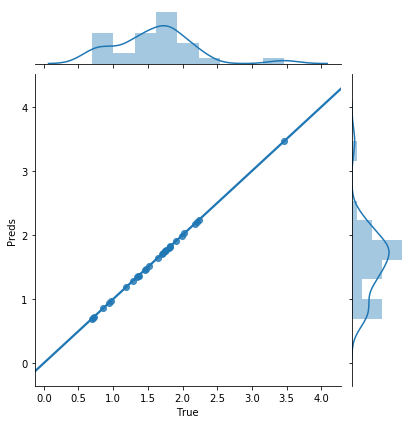

In [0]:
import seaborn as sns

df = pd.DataFrame({'Preds':y_pred_train.ravel(),'True':y})
df = df.reset_index()
#df = df.drop(['index'],axis=1)

sns.jointplot(x='True', y='Preds', data=df, kind='reg')

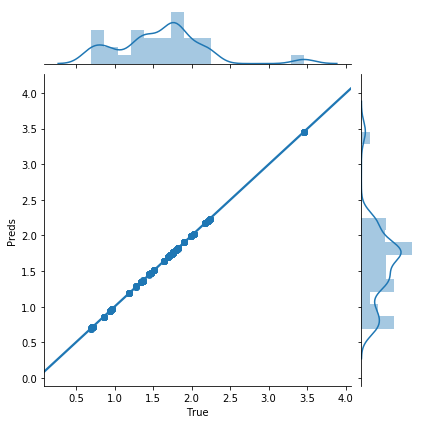

In [0]:
import seaborn as sns

df = pd.DataFrame({'Preds':y_pred_train.ravel(),'True':y})
df = df.reset_index()
#df = df.drop(['index'],axis=1)

sns.jointplot(x='True', y='Preds', data=df, kind='reg')

## Prediction on Test

In [0]:
y_pred_test = GBR.predict(X_test)
y_pred_test

array([2.13163747, 1.35879667, 1.87733459, 1.96000613, 1.66715045,
       1.66652621, 1.74349397, 1.68225605, 1.66214153, 1.4362345 ,
       1.32033554, 1.3378628 , 1.76772844, 1.34281427, 1.54660193,
       1.96983017, 1.77835879, 1.95719921, 1.13438043, 1.55308137,
       1.3799284 , 1.74417205, 2.09164841, 1.8103962 , 1.86865485])

## Approach 2

In [0]:
y_pred_test = GBR.predict(X_test)
avg_pred=[]
for i in range(0,len(y_pred_test),8):
  avg_pred.append(np.mean(y_pred_test[i:i+9]))

avg_pred

[1.6881667078078515,
 1.712702801995705,
 1.712450172560967,
 1.5785735136505445,
 1.7893819935167323,
 1.6842397585368085,
 1.7174571618656058,
 1.5920976019534614,
 1.7306402599739867,
 1.616940049249769,
 1.5462088374604255,
 1.5419941152800083,
 1.6624995038188504,
 1.6658598988930866,
 1.694621421210021,
 1.687386175809951,
 1.7292829128064704,
 1.4644944871884928,
 1.5971053603625778,
 1.7165830773907262,
 1.8196639258766056,
 1.6405871649322872,
 1.6461345120129094,
 1.6008892377308896,
 1.8070227049789225]

### Conclusion - Go with Second one. Much more generalized.